# Integration of SVM and MVO 

This notebook performs a comparison of the integrated MVO-SVM min variance portfolios obtained via the exact MIP solve vs the ADM method


In [1]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB
from google.colab import drive 
import math
import time
drive.mount('/content/gdrive')
pth = 'gdrive/My Drive/Colab Notebooks/'
import sys
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
#from svm_mvo import *
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')
wrds_svm_pca = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_PCA.pkl')
#wrds_svm_pca['Momentum'] = wrds_svm.Momentum
## Import Monthly Prices
prices = pd.read_pickle(pth + 'SVM MVO/DATA/PRICES.pkl')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.1 MB 4.3 MB/s 
Mounted at /content/gdrive


In [2]:
#read in licence info
gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
print("Required info for Gurobi:", gurobi_licence.columns)
try:
  #web license try to access it via uoft
  e = gp.Env(empty=True)
  #e.setParam('OutputFlag', 0)
  e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
  e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
  e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
  e.start()
except: 
  !chmod 755 /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey
  !/content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey {gurobi_licence.LOCAL[0]}
  e = gp.Env(empty=True)
  #chmod 755 grbgetkey
  e.start()


Required info for Gurobi: Index(['WLSACCESSID', 'LICENSEID', 'WLSSECRET', 'LOCAL'], dtype='object')
Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
info  : grbgetkey version 9.1.2, build v9.1.1rc0-30-g8af970cb
info  : Contacting Gurobi license server...
info  : License file for license ID 814416 was successfully retrieved
info  : License expires at the end of the day on 2022-07-24
info  : Saving license file...

In which directory would you like to store the Gurobi license file?
[hit Enter to store it in /opt/gurobi]: 

info  : License 814416 written to file /opt/gurobi/gurobi.lic
Academic license - for non-commercial use only - expires 2022-07-24
Using license file /opt/gurobi/gurobi.lic


In [3]:
%run /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/PYFILES/svm_mvo.py

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
Academic license - for non-commercial use only - expires 2022-07-24
Using license file /opt/gurobi/gurobi.lic


## Part 1

In [4]:
wrds_svm.columns[40:]

Index(['niy', 'oancfy', 'txty', 'dvpspq', 'mkvaltq', 'prccq', 'date',
       'DIFFYear', 'DIFFMonth', 'DIFFActualDays', 'DIFFExpectedDays',
       'DIFFExpectedDaysCorr', 'DIFFdatadate', 'DIFFsrcq', 'DIFFactq',
       'DIFFancq', 'DIFFatq', 'DIFFceqq', 'DIFFcheq', 'DIFFcogsq', 'DIFFcshiq',
       'DIFFcshopq', 'DIFFcshoq', 'DIFFcstkq', 'DIFFdlcq', 'DIFFdlttq',
       'DIFFdpq', 'DIFFepspi12', 'DIFFepspiq', 'DIFFepspxq', 'DIFFintanq',
       'DIFFinvtq', 'DIFFlctq', 'DIFFlltq', 'DIFFltq', 'DIFFniq', 'DIFFoibdpq',
       'DIFFopepsq', 'DIFFrectq', 'DIFFreq', 'DIFFsaleq', 'DIFFteqq',
       'DIFFcapxy', 'DIFFdltisy', 'DIFFdltry', 'DIFFniy', 'DIFFoancfy',
       'DIFFtxty', 'DIFFdvpspq', 'DIFFmkvaltq', 'DIFFprccq', 'ROC1', 'ROC2',
       'ROC3', 'ROC4', 'ROC5', 'INV1', 'INV2', 'INV3', 'PRO1', 'PRO2', 'PRO3',
       'PRO4', 'PRO5', 'PRO6', 'PRO7', 'LEV1', 'LEV2', 'LEV3', 'LEV4', 'LEV5',
       'RET1', 'LIQ1', 'LIQ2', 'LIQ3', 'LIQ4', 'LIQ5', 'RISK1', 'RISK2',
       'RISK3', 'GRW1', 'GRW2', 

In [5]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [6]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N] 
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
cols = ['INV3', 'PRO6', 'INV1']

Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
Y.INV1 = -1*Y.INV1
# Y['Momentum'] = wrds_tics.Momentum
#restrict the wharton research data to the columns of interest
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0)) #scale the features 
AssetLim = math.floor(N*0.5)
ret_constr = -1
soft_margin = 2500
dpi_setting = 150
Y_.head()
#['INV1', 'INV3', 'PRO5', 'LIQ2', 'LIQ4', 'LIQ5'] bad results
# ['INV3' ,  'LIQ5' ,  'GRW5'  ,  'LEV5' ,  'GRW7' ,  'Momentum' ] correlation hacking 
#'Vol', 'GRW7', 'PRO6', 'INV3', 'LEV5'

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

,INV3,PRO6,INV1
tic,,,
AAPL,-0.419213,-0.150973,0.068229
ABC,0.663853,-0.570907,0.086787
ABMD,-0.394706,-0.788425,0.311307
ABT,-0.706199,-0.354962,0.053606
ADBE,-0.776732,-0.507762,-0.036750


In [7]:
MVO_ = MVO(tics, mean, cov, ret_constr, Y_, AssetLim)
SVM_ = SVM(tics, Y_ ,  50*soft_margin)
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 10, ParamLim = 15)
SVM_MVO_Fast.MVO_.model.params.MIPGap = 0.05 

SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
SVM_MVO_Fast.MVO_.model.params.TimeLimit = 120
SVM_MVO_Fast.SVM_.model.params.TimeLimit = 60

SVM_MVO_Fast.silence_output()

SVM_MVO_Fast.initialize_soln()

ws , xs, zs , xi_mvo, xi_svm, dt, objectives_svm, objectives_mvo = SVM_MVO_Fast.solve_ADM()
print("Solution time", dt)


Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Solution time 45.141209840774536


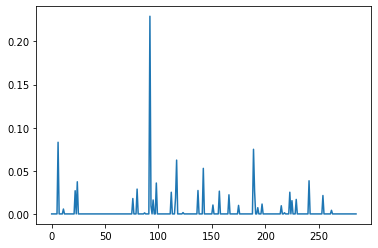

In [8]:
plt.plot(SVM_MVO_Fast.x.x)

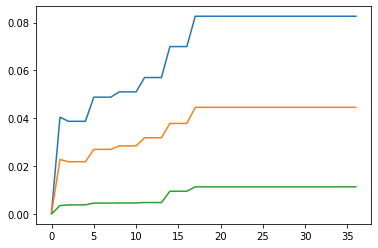

In [9]:
plt.plot(ws)

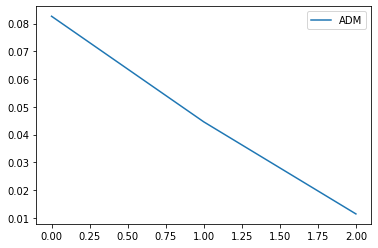

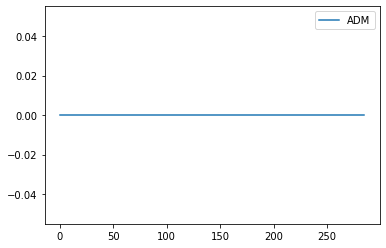

In [10]:
# plt.plot(SVM_MVO_Slck.w.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.w.x, label= 'ADM')
plt.legend();

plt.figure()
#plt.plot(SVM_MVO_Slck.xi.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.xi_mvo.x, label= 'ADM')
plt.legend();

ADM terminated with C =  10514.845254940277
ADM terminated with C =  10514.845254940277
ADM terminated with C =  10514.845254940277
ADM terminated with C =  10514.845254940277
ADM terminated with C =  10514.845254940277


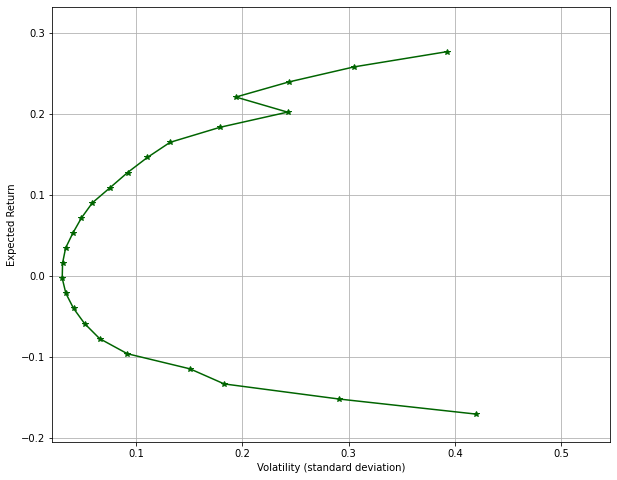

In [ ]:
adm_ef = SVM_MVO_Fast.get_frontier();

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 572 columns and 572 nonzeros
Model fingerprint: 0xdc0310da
Model has 41041 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 286 columns
Presolve time: 0.05s
Presolved: 2 rows, 286 columns, 572 nonzeros
Presolved model has 41041 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 285
 AA' NZ     : 4.104e+04
 Factor NZ  : 4.133e+04 (roughly 1 MByte of memory)
 Factor Ops : 7.921e+06 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.21402282e+05 -2.21402282e+05  1.16e+0

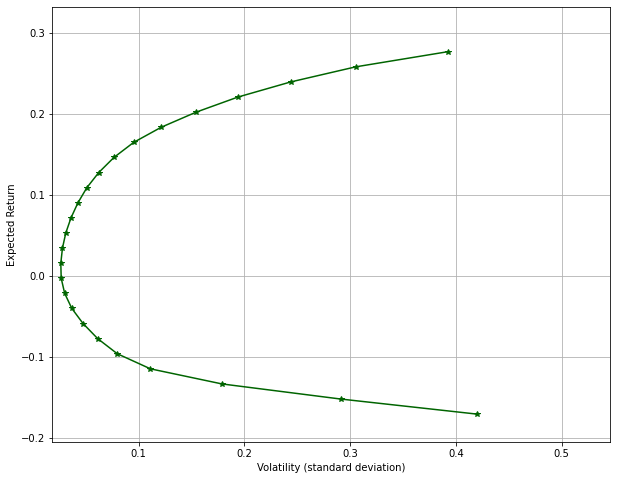

In [ ]:
MVO2 = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
             svm_choice = (False, False), print_var_frntr= False) #define an instance of the class
MVO2.set_model() #set up the model
MVO2.optimize() #find optimal solution
MVO2.model.params.outputflag = 0
mv_ef = MVO2.get_frontier()

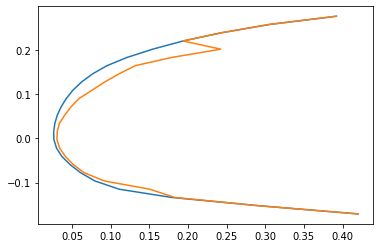

In [ ]:
plt.plot(mv_ef[0][0], mv_ef[0][1]);
plt.plot(adm_ef[0][0], adm_ef[0][1]);

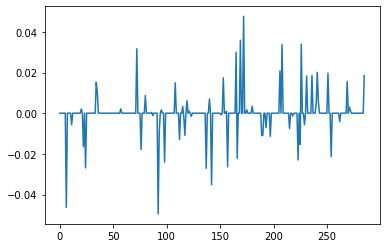

In [ ]:
plt.plot(MVO2.x.x - SVM_MVO_Fast.x.x)
prev_mvo = MVO2.x.X
prev_svm = SVM_MVO_Fast.x.x

In [11]:
return_premium = 0.1 #similiar to Costa and Kwon 
#Limit = 0.75/6 #1/6 because Costa and Kwon use 1 for 6 month period. 
T = len(rets.index) #becuase of the out sample

def evaluate_adm(rets, forecasts, wrds_svm, return_premium, model_instance, \
                 T, N, cols, TurnoverLimit):
  lr = 0.05 #learning rate for the SVM support vector
  portfolio_weights = np.zeros([T,N])
  oot_returns = np.zeros(T)
  market = np.zeros(T)
  M = len(cols)
  wis = np.zeros([T,M])
  bias = np.zeros(T)
  times = []
  i = 0 #index for dates
  w_mabs = 10**(-9) #initialize
  soln_mods = {}

  for prd in rets.index.to_list()[:T]:
    ret_ = rets.loc[prd][:N]
    cov_, mean_ = forecasts[prd]
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    return_premium_temp = return_premium 
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    #restrict the wharton research data to the columns of interest
    #modifying WRDS dataset here if required
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
    Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
    if return_premium == -1:
      ret_constr = -1
    else:
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium)
    model_instance.MVO_.tics = tics
    model_instance.SVM_.tics = tics
    model_instance.MVO_.ret_constr = ret_constr
    model_instance.MVO_.mean_ret = mean
    model_instance.MVO_.cov = cov
    model_instance.MVO_.exogenous = Y_
    model_instance.SVM_.exogenous = Y_
    mvo_cons = []
    svm_cons = []

    if i > 0: #not the first trade gets a constraint on turnover
    #turnover constraint
      x_prev = model_instance.MVO_.x.X
    #policy constraint
      w_mabs = (i/(i+1))*w_mabs + (1/(i+1))*np.abs(model_instance.SVM_.w.x).mean()
      
      w_prev = model_instance.SVM_.w.x
      b_prev = model_instance.SVM_.b.x
    #add turnover constraints
      for v, absv, curr in zip(model_instance.MVO_.x.tolist(), model_instance.MVO_.abs.tolist(), x_prev.tolist()):
        mvo_cons.append(absv >= v - curr)
        mvo_cons.append(absv >= curr - v)
      #q = cost*1/np.maximum(1, Prices)
      q = 1*1/np.maximum(1, np.ones_like(x_prev))
      mvo_cons.append(model_instance.MVO_.abs @ q <= TurnoverLimit)
    #add constraints on w
      u = model_instance.SVM_.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
      #epsilon allows change if w is 0
      svm_cons.append(model_instance.SVM_.w <= w_prev + lr*w_mabs*u + model_instance.epsilon)# 'iter constraint 1'
      svm_cons.append(model_instance.SVM_.w >= w_prev - lr*w_mabs*u - model_instance.epsilon)  #'iter constraint 2'

    try:
      model_instance.initialize_soln(constrs = mvo_cons, svm_constrs = svm_cons)
    except:
      print("Begin Relaxation")
    k = 1
    while model_instance.MVO_.model.status == 4:
      #if the model is infeasible the decrease the return constraint
      #we do not have enough turnover the modify the portfolio to achive the 
      #return target... not a great place to be
      print("Infeasible return constraint...Relaxing")
      return_premium_temp = return_premium - 0.05*k
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
      model_instance.MVO_.ret_constr = ret_constr
      model_instance.MVO_.ret_target[0].rhs = ret_constr
      try:
        model_instance.initialize_soln(constrs = mvo_cons, svm_constrs = svm_cons)
      except:
        print("Try to Relax Again")
      k = k+1


    #model_instance.silence_output()
    try:
      model_instance.solve_ADM(store_data=False, constrs = mvo_cons, svm_constrs = svm_cons)
    except:
      print("Begin Relaxation")
    k = 1
    while model_instance.MVO_.model.status == 4:
      #if the model is infeasible the decrease the return constraint
      #we do not have enough turnover the modify the portfolio to achive the 
      #return target... not a great place to be
      print("Infeasible return constraint...Relaxing")
      return_premium_temp = return_premium - 0.05*k
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
      model_instance.MVO_.ret_constr = ret_constr
      model_instance.MVO_.ret_target[0].rhs = ret_constr
      try:
        model_instance.solve_ADM(store_data=False, constrs = mvo_cons, svm_constrs = svm_cons)
      except:
        print("Try to Relax Again")
      if k > 3:
        model_instance.MVO_.ret_constr = -1
        model_instance.MVO_.ret_target[0].rhs = -1
        print("giving up ...  MVP")
        model_instance.solve_ADM(store_data=False, constrs = mvo_cons, svm_constrs = svm_cons)
        break
      k = k+1
    


    # if model_instance.model.IsMIP:
    #   soln_mods[prd] = [model_instance.model.MIPGap, return_premium_temp]
    # else:
    model_instance.w = model_instance.w.x #convert to numpy array
    model_instance.b = model_instance.b.x
    # alpha = 0.95
    # if i > 0:
    #   model_instance.MVO_.svm_w = alpha*(model_instance.SVM_.w.x) + (1- alpha)*(w_prev)
    #   model_instance.MVO_.svm_b = alpha*(model_instance.SVM_.b.x) + (1- alpha)*(b_prev)
    #   model_instance.MVO_.optimize()
    #   model_instance.x =  model_instance.MVO_.x
    #   model_instance.w =  model_instance.MVO_.svm_w #numpy
    #   model_instance.b =  model_instance.MVO_.svm_b #numpy

    soln_mods[prd] = return_premium_temp
    #oot_returns[i] = model_instance.evaluate(ret_)
    market[i] = ret_.mean()
    portfolio_weights[i, :] = model_instance.x.x
    times.append(dt)
    wis[i,:] = model_instance.w
    bias[i] = model_instance.b

    if i + 1 >= T:
      break
      
    if i%12 == 0:
      print("_"*25)
      print("Iteration ", i)
      print("Percent Complete ", i/T)
    i = i+1
  
  portfolio_weights = pd.DataFrame(portfolio_weights, index = rets.index[:T], columns = model_instance.tics)
  oot_returns = pd.Series(oot_returns, index = rets.index[:T])
  market = pd.Series(market, index = rets.index[:T])
  return (portfolio_weights, oot_returns, market, wis, bias, soln_mods, times)

In [ ]:
# adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, T, N, cols, 0.75/6)
# with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/Card05_oot_0_75.pkl", 'wb') as fp:
#   pkl.dump(adm_results, fp);

# adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, T, N, cols, 1/6)
# with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/Card05_oot_1.pkl", 'wb') as fp:
#   pkl.dump(adm_results, fp);

adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, T, N, cols, 1.25/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/Test_Card05_oot_1_25.pkl", 'wb') as fp:
  pkl.dump(adm_results, fp);



_________________________
Iteration  0
Percent Complete  0.0
ADM terminated with C =  125000.0


/content/gdrive/My Drive/Colab Notebooks/SVM MVO/PYFILES/svm_mvo.py:664: RuntimeWarning: divide by zero encountered in true_divide
  relative_diff = np.all(np.abs((self.SVM_.w.x - w_prev)/w_prev) < 0.05)


ADM terminated with C =  884.4957658827211
ADM terminated with C =  17251.39865115331
ADM terminated with C =  28303.864508247076
ADM terminated with C =  6408.8699688096685
ADM terminated with C =  76188.35338777966
ADM terminated with C =  46437.321535529634
ADM terminated with C =  46437.321535529634
ADM terminated with C =  6408.8699688096685
_________________________
Iteration  12
Percent Complete  0.04938271604938271
ADM terminated with C =  46437.321535529634
ADM terminated with C =  1451.166297985301
ADM terminated with C =  28303.864508247076
ADM terminated with C =  1451.166297985301
ADM terminated with C =  76188.35338777966
ADM terminated with C =  28303.864508247076
ADM terminated with C =  10514.845254940277
ADM terminated with C =  46437.321535529634
ADM terminated with C =  17251.39865115331
ADM terminated with C =  46437.321535529634
_________________________
Iteration  24
Percent Complete  0.09876543209876543
ADM terminated with C =  76188.35338777966
ADM terminated w

/content/gdrive/My Drive/Colab Notebooks/SVM MVO/PYFILES/svm_mvo.py:664: RuntimeWarning: invalid value encountered in true_divide
  relative_diff = np.all(np.abs((self.SVM_.w.x - w_prev)/w_prev) < 0.05)


ADM terminated with C =  200.27718652530214
ADM terminated with C =  17251.39865115331
_________________________
Iteration  168
Percent Complete  0.691358024691358
ADM terminated with C =  3906.25
ADM terminated with C =  76188.35338777966
ADM terminated with C =  2380.886043368116
ADM terminated with C =  17251.39865115331
ADM terminated with C =  17251.39865115331
ADM terminated with C =  28303.864508247076
_________________________
Iteration  180
Percent Complete  0.7407407407407407
ADM terminated with C =  17251.39865115331
ADM terminated with C =  28303.864508247076
ADM terminated with C =  125000.0
ADM terminated with C =  46437.321535529634
_________________________
Iteration  192
Percent Complete  0.7901234567901234
ADM terminated with C =  6408.8699688096685
ADM terminated with C =  46437.321535529634
ADM terminated with C =  76188.35338777966
ADM terminated with C =  76188.35338777966
ADM terminated with C =  28303.864508247076
ADM terminated with C =  6408.8699688096685
ADM 